Using cuda


  0%|          | 0/10 [00:00<?, ?epoch/s]

Эпоха [1/10], Потеря: 0.1569
Эпоха [2/10], Потеря: 0.1245
Эпоха [3/10], Потеря: 0.1320
Эпоха [4/10], Потеря: 0.1213
Эпоха [5/10], Потеря: 0.1306
Эпоха [6/10], Потеря: 0.1198
Эпоха [7/10], Потеря: 0.1017
Эпоха [8/10], Потеря: 0.1303
Эпоха [9/10], Потеря: 0.1234
Эпоха [10/10], Потеря: 0.1276


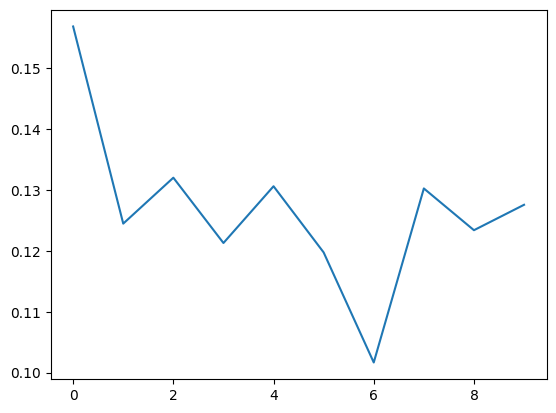

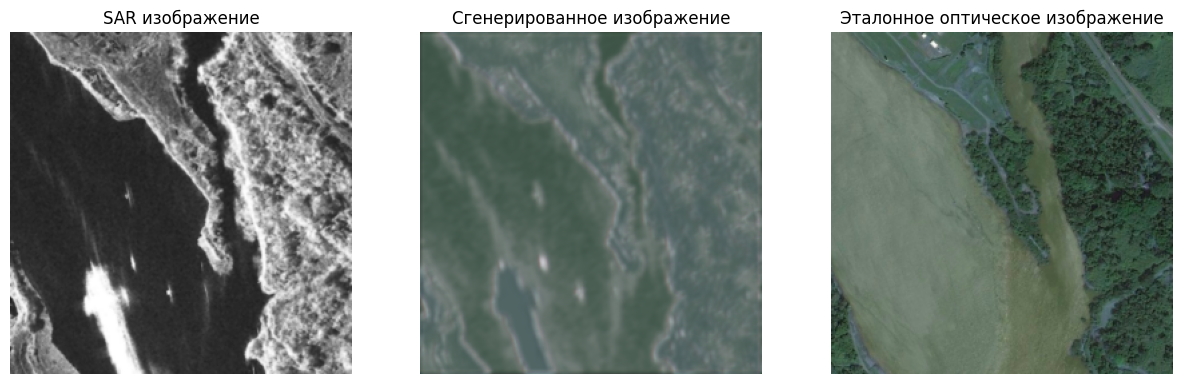

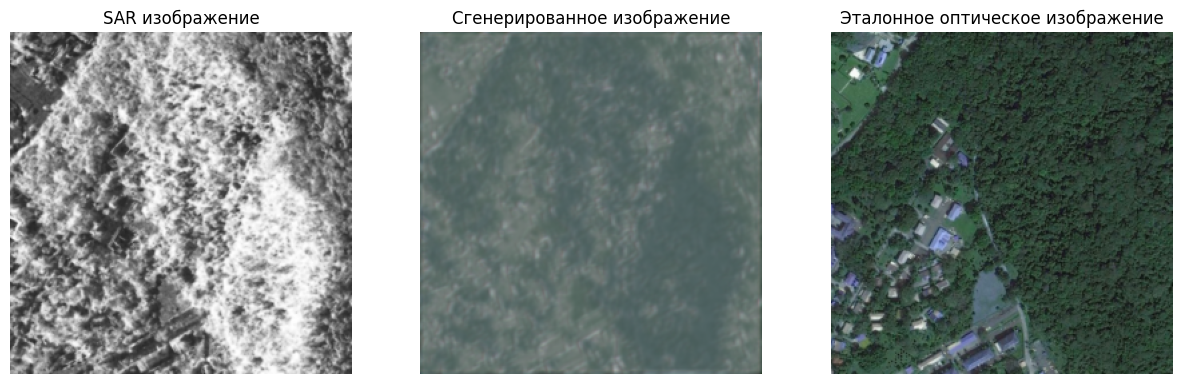

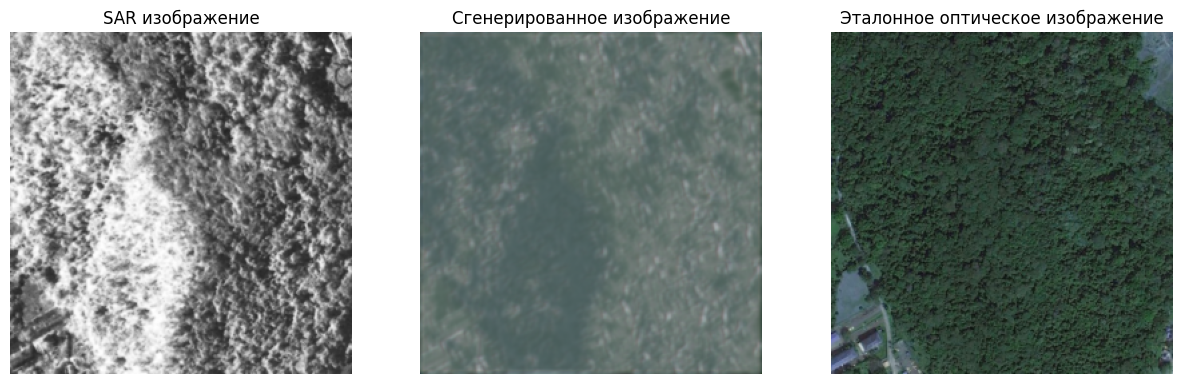

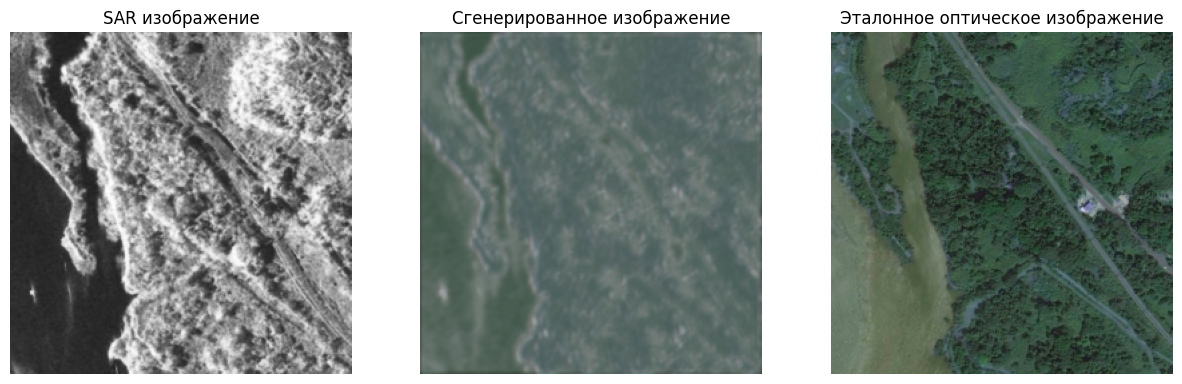

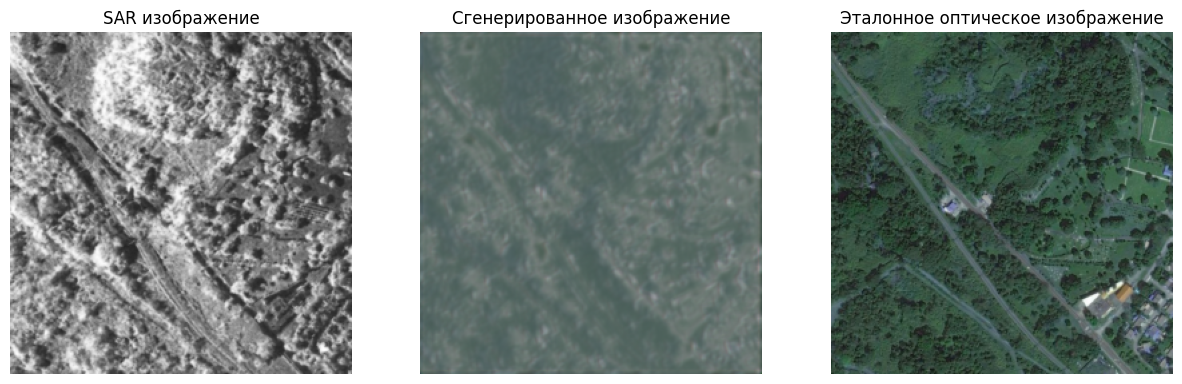

Средняя потеря на тестовых данных: 0.1322


In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Определение датасета
class SARTOOpticalDataset(Dataset):
    def __init__(self, root_dir, phase='train', transform=None):
        self.sar_dir = os.path.join(root_dir, f'{phase}A')
        self.optical_dir = os.path.join(root_dir, f'{phase}B')
        self.sar_images = sorted(os.listdir(self.sar_dir))
        self.optical_images = sorted(os.listdir(self.optical_dir))
        self.transform = transform

    def __len__(self):
        return len(self.sar_images)

    def __getitem__(self, idx):
        sar_path = os.path.join(self.sar_dir, self.sar_images[idx])
        optical_path = os.path.join(self.optical_dir, self.optical_images[idx])

        sar_image = Image.open(sar_path).convert('RGB')
        optical_image = Image.open(optical_path).convert('RGB')

        if self.transform:
            sar_image = self.transform(sar_image)
            optical_image = self.transform(optical_image)

        return sar_image, optical_image

# Трансформации
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Загрузка тренировочных данных
train_dataset = SARTOOpticalDataset('./dataset', phase='train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Загрузка тестовых данных
test_dataset = SARTOOpticalDataset('./dataset', phase='test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Определение модели
class DiffusionModel(nn.Module):
    def __init__(self):
        super(DiffusionModel, self).__init__()
        # Определите архитектуру модели здесь
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            # Добавьте необходимые слои
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )

    def forward(self, x, t):
        # Реализуйте прямой проход модели
        return self.model(x)

# Инициализация
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}')
model = DiffusionModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.L1Loss()

# Цикл обучения
losses_list = []
epochs = 10
with tqdm(total=epochs, unit='epoch') as pbar:
    for epoch in range(epochs):
        model.train()
        for sar_images, optical_images in train_dataloader:
            sar_images = sar_images.to(device)
            optical_images = optical_images.to(device)

            optimizer.zero_grad()
            outputs = model(sar_images, t=0)
            loss = criterion(outputs, optical_images)
            loss.backward()
            optimizer.step()

        losses_list.append(loss.item())
        pbar.update(1)
        print(f'Эпоха [{epoch+1}/{epochs}], Потеря: {loss.item():.4f}')

import matplotlib.pyplot as plt

plt.plot(losses_list)
plt.show()

# Оценка на тестовых данных с визуализацией результатов
model.eval()
with torch.no_grad():
    total_loss = 0
    for i, (sar_images, optical_images) in enumerate(test_dataloader):
        sar_images = sar_images.to(device)
        optical_images = optical_images.to(device)
        outputs = model(sar_images, t=0)
        loss = criterion(outputs, optical_images)
        total_loss += loss.item()

        # Отображение результатов для первых нескольких изображений
        if i == 0:
            # Denormalize если вы нормализовали изображения
            sar_images_np = sar_images.cpu().numpy()
            outputs_np = outputs.cpu().numpy()
            optical_images_np = optical_images.cpu().numpy()

            for j in range(min(len(sar_images_np), 5)):
                sar_img = sar_images_np[j].transpose(1, 2, 0)
                output_img = outputs_np[j].transpose(1, 2, 0)
                optical_img = optical_images_np[j].transpose(1, 2, 0)

                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                axs[0].imshow(sar_img)
                axs[0].set_title('SAR изображение')
                axs[0].axis('off')

                axs[1].imshow(output_img)
                axs[1].set_title('Сгенерированное изображение')
                axs[1].axis('off')

                axs[2].imshow(optical_img)
                axs[2].set_title('Эталонное оптическое изображение')
                axs[2].axis('off')

                plt.show()

    avg_loss = total_loss / len(test_dataloader)
    print(f'Средняя потеря на тестовых данных: {avg_loss:.4f}')